Problem Set 2: Sequence Labeling
=======================

- This problem set focuses on sequence labeling with Hidden Markov models and Deep Learning Models.
- The target domain is part-of-speech tagging on English and Norwegian from the Universal Dependencies dataset

You will:
- Do some basic preprocessing of the data
- Build a naive classifier that tags each word with its most common tag
- Implement a `Viterbi` Tagger using `Hidden Markov Model` in PyTorch
- Build a `Bi-LSTM` deep learning model using PyTorch
- Build a `Bi-LSTM_CRF` model using the above components (`Viterbi` and `Bi-LSTM`) 
- then implement techniques to improve your classifier and compete on Kaggle.


# 0. Setup

In order to develop this assignment, you will need [python 3.6](https://www.python.org/downloads/) and the following libraries. Most if not all of these are part of [anaconda](https://www.continuum.io/downloads), so a good starting point would be to install that.

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- [numpy](https://docs.scipy.org/doc/numpy/user/install.html)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pandas](http://pandas.pydata.org/) Dataframes

Here is some help on installing packages in python: https://packaging.python.org/installing/. You can use ```pip --user``` to install locally without sudo.

## About this assignment

- This is a Jupyter notebook. You can execute cell blocks by pressing control-enter.
- Most of your coding will be in the python source files in the directory ```gtnlplib```.
- The directory ```tests``` contains unit tests that will be used to grade your assignment, using ```nosetests```. You should run them as you work on the assignment to see that you're on the right track. You are free to look at their source code, if that helps -- though most of the relevant code is also here in this notebook. Learn more about running unit tests at http://pythontesting.net/framework/nose/nose-introduction/
- You may want to add more tests, but that is completely optional. 
- **To submit this assignment, run the script ```make-submission.sh```, and submit the tarball ```pset2-submission.tgz``` on Canvas.**

In [3]:
import sys
from importlib import reload

In [4]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [5]:
import nose

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

%matplotlib inline

In [6]:
print('My library versions')

print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('nose: {}'.format(nose.__version__))
print('torch: {}'.format(torch.__version__))

My library versions
pandas: 0.22.0
numpy: 1.14.0
matplotlib: 2.1.2
nose: 1.3.7
torch: 0.3.0.post4


To test whether your libraries are the right version, run:

`nosetests tests/test_environment.py`

In [7]:
# use ! to run shell commands in notebook
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [9]:
from collections import defaultdict, Counter

# importing all the necessary files from gtnlplib
from gtnlplib import constants, preproc, most_common, clf_base, evaluation
from gtnlplib import scorer, tagger_base, naive_bayes, hmm, viterbi, bilstm

1. Data Processing
===================
The part-of-speech tags are defined on the [universal dependencies website](http://universaldependencies.org/en/pos/index.html).

In [10]:
reload(constants);
## Define the file names
TRAIN_FILE = constants.TRAIN_FILE
DEV_FILE = constants.DEV_FILE
TEST_FILE = constants.TEST_FILE 
TEST_FILE_HIDDEN = constants.TEST_FILE_UNLABELED
NR_TRAIN_FILE = constants.NR_TRAIN_FILE
NR_DEV_FILE = constants.NR_DEV_FILE
NR_TEST_FILE = constants.NR_TEST_FILE
NR_TEST_FILE_HIDDEN = constants.NR_TEST_FILE_UNLABELED
# change the constant to test_file_unlabeled for release

- Here is demo code for using the function `conll_seq_generator(...)`. 
- The default value for max_insts is `1000000` indicating the num. of instances: and this should be enough for our dataset. 

In [11]:
## Demo
all_tags = set([])
for (words, tags) in preproc.conll_seq_generator(TRAIN_FILE):
    for tag in tags:
        all_tags.add(tag)
all_tags = sorted(all_tags)
print (all_tags)

['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


**Deliverable 1.1**: Counting words per tag. (* 1 point *)

Implement the function `get_tag_word_counts` in `most_common.py`: The function should calculate the number of occurrences of all words for each tag.

- **Input**: filename for data file, to be passed as argument to `preproc.conll_seq_generation`
- **Output**: dict of counters, where keys are tags
- **Tests**: ```test_most_common.py: test_get_top_noun_tags(),test_get_top_verb_tags()```

In [12]:
reload(most_common);

In [14]:
# this block uses your code to find the three most common words per tag
counters = most_common.get_tag_word_counts(TRAIN_FILE)
for tag,tag_ctr in counters.items():
    print (tag, tag_ctr.most_common(3))

PROPN [('Bush', 100), ('US', 81), ('Al', 78)]
PUNCT [(',', 1616), ('.', 1588), ('"', 383)]
ADJ [('other', 46), ('many', 41), ('Indian', 35)]
NOUN [('people', 53), ('time', 48), ('world', 46)]
VERB [('is', 335), ('was', 128), ('have', 110)]
DET [('the', 1926), ('a', 650), ('The', 216)]
ADP [('of', 887), ('in', 738), ('to', 380)]
AUX [('have', 139), ('was', 126), ('has', 124)]
PRON [('I', 251), ('it', 208), ('he', 131)]
PART [('to', 542), ("'s", 218), ('not', 172)]
SCONJ [('that', 304), ('if', 56), ('as', 47)]
NUM [('one', 52), ('two', 28), ('2001', 17)]
ADV [('also', 63), ('now', 54), ('when', 53)]
CONJ [('and', 932), ('or', 127), ('but', 88)]
X [('1', 3), ('2', 3), ('3', 3)]
INTJ [('Please', 15), ('please', 3), ('Well', 3)]
SYM [('$', 20), ('-', 13), ('/', 7)]


# 2. Tagging as classification 

Now you will implement part-of-speech tagging via classification.

Tagging quality is evaluated using evalTagger, which takes three arguments:
- a tagger, which is a **function** taking a list of words and a tagset as arguments and returns the predicted tags for the words
- an output filename
- a test file

You will want to use lambda expressions to create the first argument for the `eval_tagger(..)` function, as shown below.
Here's how it works. I provide a tagger that labels everything as a noun.

In [15]:
reload(tagger_base);

In [16]:
# here is a tagger that just tags everything as a noun
noun_tagger = lambda words, alltags : ['NOUN' for word in words]

confusion = tagger_base.eval_tagger(noun_tagger,'nouns.preds',all_tags=all_tags)
print (scorer.accuracy(confusion))

0.1527613022274944


** Deliverable 2.1 ** Classification-based tagging. (* 0.5 points *)

Now do the same thing as above, but building your tagger *as a classifier.* To do this, implement `make_classifier_tagger()` in `tagger_base.py`. 

- **Input**: defaultdict of weights
- **Output**: return a function that takes in (list of word tokens, list of all possible tags) $\rightarrow$ tags for each word

The function that you output should create the base-features for each token (**use the OFFSET and the TOKEN itself as base-features**)  and then use your `clf_base.predict()` function from pset 1. You are free to edit the `clf_base.predict()` function if you don't think you got it right in pset 1.
- **Tests**: ```test_classifier_tagger.py:test_classifier()```


In [17]:
reload(tagger_base);
reload(clf_base);
from gtnlplib.constants import OFFSET #OFFSET token is for each tag

- Now create a tagger with weights that predict every token to be a NOUN. 
The function `get_noun_weights` is already implemented for you.

In [18]:
classifier_noun_tagger = tagger_base.make_classifier_tagger(most_common.get_noun_weights())

In [19]:
confusion = tagger_base.eval_tagger(classifier_noun_tagger,'all-nouns.preds',all_tags=all_tags)
print (scorer.accuracy(confusion))

0.1527613022274944


**Deliverable 2.2** Tagging words by their most common tag. (* 0.5 points *)

Now build a classifier tagger that tags each word with its most common tag in the training set. To do this, implement `get_most_common_word_weights` in `most_common.py`.  

- **Input**: training file

- **Output**: defaultdict of weights

This function should return a set weights such that each word should get the tag that is most frequently associated with it in the training data. If the word does not appear in the training data, the weights should be set so that the tagger outputs the **most common tag** in the training data. For the out of vocabulary words, you need to think on how to set the weights so that you tag them by the most common tag.

- **Tests**: ```test_classifier.py:test_mcc_tagger_output(), test_mcc_tagger_accuracy()```

In [20]:
reload(most_common);
reload(clf_base);
theta_mc = most_common.get_most_common_word_weights(TRAIN_FILE)

In [21]:
tagger_mc = tagger_base.make_classifier_tagger(theta_mc)
words = ['They', 'can', 'can', 'fish']

In [22]:
tags = tagger_mc(['They','can','can','fish'],all_tags)
print (tags)

['PRON', 'AUX', 'AUX', 'NOUN']


In [23]:
tags = tagger_mc(['The','old','man','the','boat','.'],all_tags)
print (tags)

['DET', 'ADJ', 'NOUN', 'DET', 'PROPN', 'PUNCT']


- Now let's run your tagger on the dev data.

In [24]:
confusion = tagger_base.eval_tagger(tagger_mc,'most-common.preds',all_tags=all_tags)
print (scorer.accuracy(confusion))

0.8113879003558719


### Naive Bayes as a tagger.
    
- You can use your Naive Bayes classifier form pset1 to set the weights for the classifier tagger. We have added in a helper function `naive_bayes.get_nb_weights(..)`. Make sure to retain this function, when you copy your code.
- If you don't think you got it right in pset1, you are free to change it now. If you got it right, then just examine the performance of naive bayes as tagger in the following blocks. There is no test or deliverable for this part.
- Note that, for text classification, we had a bag of words feature vector and label for each document. For POS tagging, in order to estimate the weights for the classifier tagger, we will consider each token to be its own document. The following helper code converts the dataset to token level bag-of-words feature vector and labels.


In [361]:
reload(naive_bayes);
nb_weights = naive_bayes.get_nb_weights(TRAIN_FILE, .01)

- This gives weights for each tag-word pair that represent $\log P(word \mid tag)$

In [362]:
# obtaining vocab of words
vocab = set([word for tag,word in nb_weights.keys() if word is not constants.OFFSET])

In [363]:
print (len(vocab))

6912


In [364]:
print (sum(np.exp(nb_weights[('ADJ',word)]) for word in vocab))
print (sum(np.exp(nb_weights[('NOUN',word)]) for word in vocab))
print (sum(np.exp(nb_weights[('PUNCT',word)]) for word in vocab))

0.9999999999998932
1.0000000000000748
0.999999999999969


- We have zero weights for OOV terms -- think about how this affects the classification here!

In [365]:
print (nb_weights[('ADJ','baaaaaaaaad')])

0.0


In [366]:
print (nb_weights[('VERB',constants.OFFSET)])
print (nb_weights[('ADV',constants.OFFSET)])
print (nb_weights[('PRON',constants.OFFSET)])

-2.1314729713701412
-3.0977985544826994
-2.8092821056787987


- Offsets should correspond to log-probabilities $\log P(y)$ such that $\sum_y P(y) = 1$.

In [367]:
sum(np.exp(nb_weights[(tag,constants.OFFSET)]) for tag in all_tags)

3.0

- Now let us look at the accuracy of our naive_bayes tagger.

In [368]:
confusion = tagger_base.eval_tagger(tagger_base.make_classifier_tagger(nb_weights),'nb-simple.preds')
dev_acc = scorer.accuracy(confusion)
print (dev_acc)

0.8092790299195993


- Just as good as the heuristic tagger from above.

# 3. Viterbi Algorithm

In this section you will implement the Viterbi algorithm in **PyTorch**. To get warmed up, let's work out an example by hand. For simplicity, there are only two tags, **N**OUN and **V**ERB. Here are the parameters:

| | Value |
| ------------- |:-------------:|
| $\log P_E(\cdot|N)$ | they: -1, can: -3, fish: -3 |
| $\log P_E(\cdot|V)$ | they: -11, can: -2, fish: -4 |
| $\log P_T(\cdot|N)$ | N: -5, V: -2, END: -2 |
| $\log P_T(\cdot|V)$ | N: -1, V: -3, END: -3 |
| $\log P_T(\cdot|\text{START})$ | N :-1, V :-2 |

where $P_E(\cdot|\cdot)$ is the emission probability and $P_T(\cdot|\cdot)$ is the transition probability.
 
- In class we discussed the sentence *They can fish*. 
- Now work out a more complicated example: "*They can can fish*", where the second "*can*" refers to the verb of putting things into cans.
 
** Deliverable 3.1 ** Work out the trellis by hand, and fill in the table in the file **```text-answers.md```** (*0.5 points*)

## Implementing Viterbi ##

Here are some predefined weights, corresponding to the weights from the problem 3.1.

In [369]:
START_TAG = constants.START_TAG
END_TAG = constants.END_TAG
UNK = constants.UNK

nb_weights={('NOUN','they'):-1,\
            ('NOUN','can'):-3,\
            ('NOUN','fish'):-3,\
            ('VERB','they'):-11,\
            ('VERB','can'):-2,\
            ('VERB','fish'):-4,}
hmm_trans_weights={('NOUN','NOUN'):-5,\
                   ('VERB','NOUN'):-2,\
                   (END_TAG,'NOUN'):-2,\
                   ('NOUN','VERB'):-1,\
                   ('VERB','VERB'):-3,\
                   (END_TAG,'VERB'):-3,\
                   ('NOUN',START_TAG):-1,\
                   ('VERB',START_TAG):-2}

- Below, observe that we are calculating `tag_to_ix, ix_to_tag, word_to_ix`. These are useful to access a particular emission score for a particular token and a tag. Look through the variables: tag_transition_probs and emission_probs below and it should be clear.

** Deliverable 3.2 ** Complete the ```hmm.compute_weights_variables(...)``` function in `hmm.py` file (*0.5 points*) The function should basically convert the weights to respective pytorch variables .

- **Inputs** :
    - `nb_weights`: emission_weights: dictionary of weights
    - `hmm_trans_weights`: dictionary of weights
    - `vocab`: list of all the words
    - `word_to_ix`: a dictionary that maps each word in the vocab to a unique index. **Does not have the OFFSET_TOKEN.**
    - `tag_to_ix`: a dictionary that maps each tag (including the `START_TAG` and the `END_TAG`) to a unique index.  

- **Outputs** : returns two torch Variables
    - `emission_probs`: torch Variable of a matrix of size `Vocab x Tagset_size`: 
        such that for a specific weight say `(word1, tag1):value` would result in
        `emission_probs[word_to_ix[word1]][tag_to_ix[tag1]]=value`, else a zero. Also, make sure to set weights such that `START_TAG` and `END_TAG` cannot generate any word. **Make sure to ignore the OFFSET weights that might be present in the nb_weights. Consider the words only in your word_to_ix.**
        
    - `tag_transition_probs`: torch Variable of a matrix of size `Tagset_size x Tagset_size`: 
        such that for a specific feature say `(tag1, tag2):value` 
        where tag1 is my succeeding tag, tag2 is my current tag. 
        This would result in `tag_transition_probs[tag_to_ix[tag1]][tag_to_ix[tag2]]=value`. 
        Also ensure to set the other weights such that there are no illegal transitions 
        (like from some tag to START_TAG -or- from END_TAG to some other tag)  

- **Tests**: ```test_viterbi.py: test_compute_hmm_weights_variables()```

Hint: Use `-np.inf` as weights for illegal transitions.

In [370]:
reload(hmm);
word_to_ix={'they':0, 'can':1, 'fish':2, UNK:3}
tag_to_ix = {START_TAG:0, 'NOUN':1, 'VERB':2, END_TAG:3}
ix_to_tag = {v:k for k,v in tag_to_ix.items()}
all_tags = [START_TAG, 'NOUN', 'VERB', END_TAG]
words = ['they', 'can', 'fish']
vocab = ['they','can','fish',UNK]

# note that we are also including an UNK token: this will be helpful later

In [371]:
emission_probs, tag_transition_probs = hmm.compute_weights_variables(nb_weights, hmm_trans_weights, vocab, 
                                                                     word_to_ix, tag_to_ix)

In [372]:
print (tag_transition_probs)
# tag_transition_probs[0] corresponds to scores for START_TAG from START_TAG, NOUN, VERB, END_TAG
# tag_transition_probs[1] corresponds to scores for NOUN from START_TAG, NOUN, VERB, END_TAG
# tag_transition_probs[2] corresponds to scores for VERB from START_TAG, NOUN, VERB, END_TAG
# tag_transition_probs[3] corresponds to scores for END_TAG from START_TAG, NOUN, VERB, END_TAG

Variable containing:
-inf -inf -inf -inf
 -1  -5  -1 -inf
 -2  -2  -3 -inf
-inf  -2  -3 -inf
[torch.FloatTensor of size 4x4]



In [373]:
print (emission_probs)
# emission_probs[0] corresponds to scores for the token 'they' for START_TAG, NOUN, VERB, END_TAG
# emission_probs[1] corresponds to scores for the token 'can' for START_TAG, NOUN, VERB, END_TAG
# emission_probs[2] corresponds to scores for the token 'fish' for START_TAG, NOUN, VERB, END_TAG
# emission_probs[2] corresponds to scores for the token 'UNK' for START_TAG, NOUN, VERB, END_TAG

Variable containing:
-inf  -1 -11 -inf
-inf  -3  -2 -inf
-inf  -3  -4 -inf
-inf   0   0 -inf
[torch.FloatTensor of size 4x4]



- we will be using these emission scores as inputs for each token in the input in the following function: ```viterbi_step()```.

**Deliverable 3.3** The Viterbi recurrence. (*0.5 point*)

Implement `viterbi_step` in `gtnlplib/viterbi.py`. This is the method that will compute the best path score and corresponding back pointer for a particular token in the sentence for all possible tags, which you will later call from the main viterbi routine. You will also be using this later for the `Bi-LSTM_CRF` model.

### Inputs
- `all_tags`: list of all tags: includes both the `START_TAG` and the `END_TAG`
- `tag_to_ix`: a dictionary that maps each tag (including the `START_TAG` and the `END_TAG`) to a unique index: this is useful to access the respective tag transition scores from the tag_transition_probs variable.
- `cur_tag_scores`: pytorch Variable that contains the local emission score for each tag for the current token in the sentence.
    - `cur_tag_scores` size is : `[ len(all_tags) ] `
- `transition_scores`: pytorch Variable that contains the `tag_transition_scores`. 
    - `transition_scores` size is : `[ len(all_tags) x len(all_tags) ]` 
- `prev_scores`: pytorch Variable that contains the scores for each tag for the previous token in the sentence.
    - `prev_scores` size is : `[ 1 x len(all_tags) ] `

### Outputs
- `viterbivars`: a pytorch Variable that contains the global scores for each tag for the current token in the sentence
- `bptrs`: a list of idx that contains the best_previous_tag for each tag for the current token in the sentence

### Tests
- ```test_viterbi.py: test_viterbi_step_init()```  

There are a lot of inputs, but the code itself will not be very complex. Make sure you understand what each input represents before starting to write a solution.

**Do not convert the pytorch variables into numpy. You will be using this function in BiLSTM-CRF model later on and you need the computation graph to be intact in order to backpropagate.**

- Consider the sentence: `'they can can fish'`
- Let us observe the viterbi scores at each of the tokens 'they', 'can', 'can', 'fish'.
- We will walk through this example and all along: these scores should match with the scores you obtained when you worked it out by hand.
- **Please note the dimensions of the tensors below**

In [374]:
reload(viterbi);
initial_vec = np.full((1, len(all_tags)),-np.inf) 
initial_vec[tag_to_ix[START_TAG]][0] = 0 #setting all the score to START_TAG
prev_scores = viterbi.get_torch_variable(initial_vec)
# these are the previous scores for each_tag: START_TAG, NOUN, VERB, END_TAG
print (prev_scores)

Variable containing:
  0 -inf -inf -inf
[torch.FloatTensor of size 1x4]



- The block above says that the only possible previous tag at $m=1$ is `START_TAG`
- Now let us look at the tag scores for the first token 'they'

In [375]:
print (all_tags)

['--START--', 'NOUN', 'VERB', '--END--']


- Carefully observe all the inputs to the `viterbi_step(..)` function here.
    - `all_tags`: is the list of all possible tags here
    - `tag_to_ix`: a mapping from tags to unique ids: this is useful to access the respective tag transition scores from the `tag_transition_probs` variable.
    - `cur_tag_scores`: observe that from previous section: `emission_probs` indicates the emission scores for each tag for each word they: since we will be tagging the word 'they' right now in our example: we will be using ```emission_probs[0]```: note that '0' is the id for our word 'they'.Thus, we send in `emission_probs[0]` as our cur_tag_scores
    - `tag_transition_probs`: tag transition probabilities
    - `prev_scores`: prev_scores obtained: we have initially calculated these scores above such that the `START_TAG` has all the score.

In [376]:
reload(viterbi);
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix, 
                                          emission_probs[0], 
                                          tag_transition_probs,
                                          prev_scores)

- The following are the scores obtained for each tag for the word token 'they' and the backpointer refers to that particular previous tag which resulted in that score.

In [377]:
scores = viterbivars

for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v].data.numpy(), ' back-pointer-tag: ', 
           ix_to_tag[bptrs[v]])

tag:  --START--  score:  [-inf]  back-pointer-tag:  --START--
tag:  NOUN  score:  [-2.]  back-pointer-tag:  --START--
tag:  VERB  score:  [-13.]  back-pointer-tag:  --START--
tag:  --END--  score:  [-inf]  back-pointer-tag:  --START--


- `NOUN` has the highest score for the current tag, and its backpointer is to `START_TAG`
- Now, let us look at the scores for the tags for the second token 'can'. Send in `emission_probs[1]` as our `current_tag_scores`, and update `prev_scores` to be the scores obtained for $m=1$.

In [378]:
reload(viterbi)
prev_scores = viterbi.get_torch_variable([-np.inf, -2, -13, -np.inf])
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                          emission_probs[1],
                                          tag_transition_probs,
                                          prev_scores)

- The following are the scores obtained for each tag for the word token 'can' and its respective back_pointer tag.

In [379]:
scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v].data.numpy(), ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  [-inf]  back-pointer-tag:  --START--
tag:  NOUN  score:  [-10.]  back-pointer-tag:  NOUN
tag:  VERB  score:  [-6.]  back-pointer-tag:  NOUN
tag:  --END--  score:  [-inf]  back-pointer-tag:  --START--


- Now, Below, let us look at the scores for the tags for the third token 'can'. So, now we send in `emission_probs[1]` as our `current_tag_scores` and we update `prev_scores` to be the scores obtained for the previous token 'can'.

In [380]:
prev_scores = viterbi.get_torch_variable([-np.inf, -10, -6, -np.inf]) 
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                          emission_probs[1],
                                          tag_transition_probs,
                                          prev_scores)

In [381]:
scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v].data.numpy(), ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  [-inf]  back-pointer-tag:  --START--
tag:  NOUN  score:  [-10.]  back-pointer-tag:  VERB
tag:  VERB  score:  [-11.]  back-pointer-tag:  VERB
tag:  --END--  score:  [-inf]  back-pointer-tag:  --START--


 - Now, let us look at the scores for the tags for the last token 'fish', So, now we send in `emission_probs[2]` as our `current_tag_scores` and we update `prev_scores` to be the scores obtained above for the previous token 'can'

In [382]:
# try they can can can can fish
prev_scores = viterbi.get_torch_variable([-np.inf, -10, -11, -np.inf]) 
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                          emission_probs[1],
                                          tag_transition_probs,
                                          prev_scores)

scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v].data.numpy(), ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  [-inf]  back-pointer-tag:  --START--
tag:  NOUN  score:  [-15.]  back-pointer-tag:  VERB
tag:  VERB  score:  [-14.]  back-pointer-tag:  NOUN
tag:  --END--  score:  [-inf]  back-pointer-tag:  --START--


In [383]:
# try they can can can can fish
prev_scores = viterbi.get_torch_variable([-np.inf, -15, -14, -np.inf]) 
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                          emission_probs[1],
                                          tag_transition_probs,
                                          prev_scores)

scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v].data.numpy(), ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  [-inf]  back-pointer-tag:  --START--
tag:  NOUN  score:  [-18.]  back-pointer-tag:  VERB
tag:  VERB  score:  [-19.]  back-pointer-tag:  NOUN
tag:  --END--  score:  [-inf]  back-pointer-tag:  --START--


In [384]:
# try they can can can can fish
reload(viterbi)
prev_scores = viterbi.get_torch_variable([-np.inf, -18, -19, -np.inf]) 
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                          emission_probs[2],
                                          tag_transition_probs,
                                          prev_scores)

scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v].data.numpy(), ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  [-inf]  back-pointer-tag:  --START--
tag:  NOUN  score:  [-23.]  back-pointer-tag:  VERB
tag:  VERB  score:  [-24.]  back-pointer-tag:  NOUN
tag:  --END--  score:  [-inf]  back-pointer-tag:  --START--


In [385]:
# try they can can can can fish
prev_scores = viterbi.get_torch_variable([-np.inf, -23, -24, -np.inf]) 
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                          [-30, -30, -30, 0],
                                          tag_transition_probs,
                                          prev_scores)

scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v].data.numpy(), ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  [-inf]  back-pointer-tag:  --START--
tag:  NOUN  score:  [-55.]  back-pointer-tag:  VERB
tag:  VERB  score:  [-55.]  back-pointer-tag:  NOUN
tag:  --END--  score:  [-25.]  back-pointer-tag:  NOUN


In [51]:
prev_scores = viterbi.get_torch_variable([-np.inf, -10, -11, -np.inf])
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                           emission_probs[2],
                                           tag_transition_probs,
                                           prev_scores)

In [52]:
scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v].data.numpy(), ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  [-inf]  back-pointer-tag:  --START--
tag:  NOUN  score:  [-15.]  back-pointer-tag:  VERB
tag:  VERB  score:  [-16.]  back-pointer-tag:  NOUN
tag:  --END--  score:  [-inf]  back-pointer-tag:  --START--


**Deliverable 3.4** Build the Viterbi trellis. (*0.5 points*)

This function should compute the `best_path` and the `path_score`. This function takes in the `emission_scores` for each particular token in the sentence, the `tag_transitions_weight` and returns the best set of tags for that particular sequence. Use `viterbi_step` to implement `build_trellis` in `viterbi.py` in Pytorch. 

This function should take:
- **Inputs**:
    - `all_tags`: a list of all tags: includes START_TAG and END_TAG
    - `tag_to_ix`: a dictionary that maps each tag to a unique id.
    - `cur_tag_scores`: a list of pytorch Variables where each contains the local emission score for each tag for that particular token in the sentence, len(cur_tag_scores) will be equal to len(words): each pytorch variables size would be equal to len(all_tags) indicating the score for each_tag.
    - `transition_scores`: pytorch Variable (a matrix) that contains the tag_transition_scores

- **Outputs**:
    - `path_score`: the score for the best_path
    - `best_path`: the actual best_path, which is the list of tags for each token: exclude the `START_TAG` and `END_TAG` here.   
    
- **Tests**: ```test_viterbi.py: test_trellis_score(), test_build_trellis()```
First, make sure to pass the ```test_trellis_score()``` test and then move on to the ```test_build_trellis()``` test.

** Note that for the input cur_tag_scores: we are sending in a list of pytorch variables: one for each token in the sentence to be tagged **

In [386]:
# make sure START_TAG and END_TAG are in all_tags
print (all_tags)

['--START--', 'NOUN', 'VERB', '--END--']


- consider the same sentence as above: 'they can can fish'

In [387]:
words = 'they can can fish'.split()
print (words)
print (word_to_ix)
print(tag_to_ix)

['they', 'can', 'can', 'fish']
{'they': 0, 'can': 1, 'fish': 2, '<UNK>': 3}
{'--START--': 0, 'NOUN': 1, 'VERB': 2, '--END--': 3}


- Below, we create `cur_tag_scores` using the `emission_probs` for each word in the sentence `'they can can fish'`

In [389]:
#preparing cur_tag_scores for the above sentence 'they can can fish'
cur_tag_scores=[emission_probs[0],emission_probs[1],emission_probs[1],emission_probs[2]];

- Complete the code to obtain the correct path_score initially and then use the backpointers to obtain the best_path. 
- Observe the inputs we are sending in for our example: 'they can can fish'
    - `all_tags`: list of all tags including the `START_TAG` and `END_TAG`
    - `tag_to_ix`: a mapping from tags to their unique ids
    - `cur_tag_scores`: a list of pytorch variables: where each one is the score for each tag for a particular token. We send in these scores for each token in the sentence.
    - `tag_transition_probs`: tag transition probabilities

In [395]:
reload(viterbi);

In [396]:
path_score, best_path = viterbi.build_trellis(all_tags, 
                                                  tag_to_ix, 
                                                  cur_tag_scores, 
                                                  tag_transition_probs)

In [397]:
print (best_path)
print (path_score.data[0])

['NOUN', 'VERB', 'NOUN', 'VERB', 'VERB', 'NOUN']
-25.0


In [398]:
reload(viterbi)
sentence = ['they','can','can','can','can','fish']
cur_tag_scores = [emission_probs[word_to_ix[w]] for w in sentence]

path_score, best_path = viterbi.build_trellis(all_tags, 
                                                  tag_to_ix, 
                                                  cur_tag_scores, 
                                                  tag_transition_probs)
print(best_path)
print(path_score)

['NOUN', 'VERB', 'NOUN', 'VERB', 'VERB', 'NOUN']
Variable containing:
-25
[torch.FloatTensor of size 1]



# 4. Hidden Markov Model: Estimation

You will now implement the estimatation for a hidden Markov model.

We'll start with the tag transitions.

**Deliverable 4.1** (*0.5 points* for 4650, *0.25 points* for 7650) Complete the function `most_common.get_tag_trans_counts()`.  This function should get the tag transition counts from the each tag to all possible tags. Don't forget to add the transitions from the `START_TAG` and the transitions from the `END_TAG`.

You should use the `preproc.conll_seq_generator()` function.  

- **Inputs**: `trainfile`, name of file containing training data
- **Outputs**: a dictionary where keys are current tags and values are counters of succeeding tags.
- **Tests**: ```test_hmm_trans_counts.py: test_tag_trans_counts()```  


In [351]:
reload(most_common);
tag_trans_counts = most_common.get_tag_trans_counts(TRAIN_FILE)

This function returns a dict of counters, where the keys are tags.

Each counter is the frequency of tags following a given tag, e.g.:

In [352]:
print (tag_trans_counts['DET'])
print (tag_trans_counts[START_TAG])

Counter({'NOUN': 1753, 'ADJ': 866, 'PROPN': 562, 'VERB': 65, 'PUNCT': 61, 'ADV': 59, 'NUM': 55, 'DET': 29, 'ADP': 29, 'PRON': 10, 'AUX': 7, 'X': 7, 'SYM': 2})
Counter({'PRON': 422, 'PROPN': 327, 'DET': 284, 'ADV': 172, 'ADP': 142, 'NOUN': 108, 'PUNCT': 80, 'CONJ': 79, 'SCONJ': 75, 'ADJ': 67, 'VERB': 64, 'X': 51, 'NUM': 42, 'AUX': 42, 'INTJ': 31, 'SYM': 9, 'PART': 5})


**Deliverable 4.2** Estimate transition log-probabilities for an HMM. (*0.5 points* for 4650, *0.25 points* for 7650)

Implement `compute_transition_weights` in `hmm.py`. This function should return a dictionary of weights such that ```weights[(tag2,tag1)]``` = indicates the weights for transitions from `tag1` $\rightarrow$ `tag2`. These weights will be used later for the Viterbi Tagger.

### Inputs
- Transition counts (generated from `get_tag_trans_counts`)
- Smoothing

### Outputs
- Defaultdict with weights for transition features, in the form $[(y_m,y_{m-1})]$

### Tests
```test_hmm_trans.py: test_hmm_trans_weights_sum_to_one(), test_hmm_trans_weights_exact_vals() ```  

Hints: 

- Don't forget to assign smoothed probabilities to transitions which do not appear in the counts. 
- Do not assign probabilities for transitions to the `START_TAG`, which can only come first. This will also affect your computation of the denominator, since you are not smoothing the probability of transitions to the `START_TAG`.
- Don't forget to assign probabilities to transitions to the `END_TAG`; this too will affect your denominator.
- As always, probabilities should sum to one (this time conditioned on the previous tag)

In [409]:
reload(hmm);

In [410]:
hmm_trans_weights = hmm.compute_transition_weights(tag_trans_counts,.001)

In [411]:
print (tag_trans_counts[START_TAG]['NOUN'], hmm_trans_weights[('NOUN',START_TAG)])
print (tag_trans_counts[START_TAG]['VERB'], hmm_trans_weights[('VERB',START_TAG)])
print (tag_trans_counts['DET']['VERB'], hmm_trans_weights[('VERB','DET')])
print (tag_trans_counts['DET']['INTJ'], hmm_trans_weights[('INTJ','DET')])
print (tag_trans_counts['DET']['NOUN'], hmm_trans_weights[('NOUN','DET')])
print (tag_trans_counts['VERB'][START_TAG], hmm_trans_weights[(START_TAG,'VERB')])
print (hmm_trans_weights[('VERB',END_TAG)])

108 -2.9187709731609703
64 -3.4420127512639795
65 -3.9875482805835087
0 -15.069706213958325
1753 -0.6928664796044606
0 -inf
-inf


These log-probabilities should normalize to when summing over $y_m$

In [412]:
#calculating all tags here, we also add END_TAG here.
all_tags = sorted(list(tag_trans_counts.keys()) + [END_TAG])
print (sum(np.exp(hmm_trans_weights[(tag,'NOUN')]) for tag in all_tags))
print (sum(np.exp(hmm_trans_weights[(tag,'SYM')]) for tag in all_tags))
print (sum(np.exp(hmm_trans_weights[(tag,'ADJ')]) for tag in all_tags))

0.9999999999999998
1.0
0.9999999999999999


- **Now let us compute the weight variables for the whole dataset**
- So, we recalculate them below.

In [415]:
#recalculating nb_weights for the whole dataset
reload(naive_bayes);
nb_weights = naive_bayes.get_nb_weights(TRAIN_FILE, .01)

In [416]:
# recalculating tag_to_ix={}
tag_to_ix={}
for tag in list(all_tags):
    if tag not in tag_to_ix:
        tag_to_ix[tag]=len(tag_to_ix)
print (tag_to_ix)

{'--END--': 0, '--START--': 1, 'ADJ': 2, 'ADP': 3, 'ADV': 4, 'AUX': 5, 'CONJ': 6, 'DET': 7, 'INTJ': 8, 'NOUN': 9, 'NUM': 10, 'PART': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}


- **Note about OOV's**: We provide a helper function to calculate the `vocab` as shown below. We add an `UNK` token to the `vocab`. This is useful because, when we don't find a token's emission weight, we choose the `UNK` tokens weight and proceed with our tagging.

In [417]:
# recalculating vocab for the whole dataset now. # we also add an UNK token to the vocab here
reload(most_common);
reload(hmm)
vocab, word_to_ix = most_common.get_word_to_ix(TRAIN_FILE) #obtains all the words in the file

In [418]:
emission_probs, tag_transition_probs = hmm.compute_weights_variables(nb_weights, hmm_trans_weights, 
                                                                     vocab, word_to_ix, tag_to_ix)


**Deliverable 4.3** (*0.5 points*)

We can now combine `Viterbi` and the `HMM` weights to compute the tag sequence for the example sentence. Make sure your implementation passes the test for this deliverable, and **explain (in `text-answers.md`) whether you think these predicted tags are correct**, based on your understanding of the universal part-of-speech tag set.

- **Tests**: ```test_hmm.py: test_hmm_on_example_sentence()```

In [419]:
# make sure all_tags has END_TAG
print (all_tags)

['--END--', '--START--', 'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


In [420]:
reload(viterbi);
path_score, best_path = viterbi.build_trellis(all_tags,
                      tag_to_ix,
                      [emission_probs[word_to_ix[w]] for w in ['they', 'can', 'can', 'fish','.']], 
                      tag_transition_probs)

print (best_path, path_score.data.numpy())

['PRON', 'AUX', 'AUX', 'NOUN', 'PUNCT'] [-32.44558]


**Deliverable 4.4** (*0.5 points*)

- Run your HMM tagger on the dev data and test data, using the code blocks below.
- **Tests**: ```test_hmm.py: test_hmm_dev_accuracy(), test_hmm_test_accuracy()```

- Observe that, based on our definition of the viterbi function, we need to send in two sets of important scores to the `build_trellis()` function
    - cur_tag_scores: a list of emission scores for each tag for each token in the sentence
    - tag_transition_probs: tag transition scores
- When using the `HMM` with `Viterbi` Tagger: we have calculated the `cur_tag_scores` using the `naive_bayes_weights` and `tag_transition_probs` in 4.1.
- As I have already mentioned above, for `cur_tag_scores`, we are sending in a list of pytorch variables: one for each token in the sentence to be tagged
- Below, in the tagger that we create: we first calculate the set of `cur_tag_scores` for the words in the sentence and then send them in. 


In [421]:
reload(viterbi);

- Observe the way `cur_tag_scores` is computed in the loop below: 
    - For each particular word in a sentence: we assign the respective emission scores if it is present in our `vocab`, else we assign the emission_scores of an `UNK` token.
    - This is repeated everywhere from now on.

In [422]:
# this is just for fun
for i,(words,_) in enumerate(preproc.conll_seq_generator(DEV_FILE)):
    cur_tag_scores = [emission_probs[word_to_ix[w]] 
                      if w in word_to_ix else emission_probs[word_to_ix[UNK]] for w in words]
    
    pred_tags = viterbi.build_trellis(all_tags,
                                      tag_to_ix,
                                      cur_tag_scores,
                                      tag_transition_probs)[1]
    for word,pred_tag in zip(words,pred_tags):
        print ("%s/%s"%(word,pred_tag),end=" ")
    print ('\n')
    if i >= 2: break

From/ADP the/DET AP/NOUN comes/VERB this/DET story/NOUN :/PUNCT 

President/PROPN Bush/PROPN on/ADP Tuesday/PROPN nominated/PROPN two/NUM individuals/NOUN to/PART replace/VERB retiring/VERB jurists/NOUN on/ADP federal/ADJ courts/NOUN in/ADP the/DET Washington/PROPN area/NOUN ./PUNCT 

Bush/PROPN nominated/PROPN Jennifer/PROPN M./PROPN Anderson/VERB for/ADP a/DET 15/NUM -/PUNCT year/NOUN term/NOUN as/ADP associate/NOUN judge/NOUN of/ADP the/DET Superior/ADJ Court/NOUN of/ADP the/DET District/PROPN of/ADP Columbia/PROPN ,/PUNCT replacing/PRON Steffen/PROPN W./PROPN Graae/PROPN ./PUNCT 



In [423]:
tagger = lambda words, all_tags : viterbi.build_trellis(all_tags, 
                                                        tag_to_ix,
                                                            [emission_probs[word_to_ix[w]] 
                                                             if w in word_to_ix 
                                                             else emission_probs[word_to_ix[UNK]] 
                                                             for w in words],
                                                            tag_transition_probs)[1]
confusion = tagger_base.eval_tagger(tagger,'hmm-dev-en.preds', all_tags)

In [424]:
print (scorer.accuracy(confusion))

0.8389350204296824


In [425]:
tagger_base.apply_tagger(tagger,'hmm-te-en.preds',all_tags, testfile=TEST_FILE_HIDDEN)

In [1325]:
# you don't have en-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(TEST_FILE,'hmm-te-en.preds')
print (scorer.accuracy(te_confusion))

FileNotFoundError: [Errno 2] No such file or directory: 'data/en-ud-test.conllu'

### Part-of-Speech Tagging in Norwegian
**Deliverable 4.5** (*0.5 points*)
- Now, let us do part of speech tagging for data in Norwegian language using the Viterbi Tagger.
- **Tests**: ```test_hmm.py: test_nr_hmm_dev_accuracy(), test_nr_hmm_test_accuracy()```

- First, we calculate the `nb_weights`/emission weights for the norwegian language in a similar way as we did for the english language.

In [80]:
#recalculating nb_weights for the whole dataset
nb_weights_nr = naive_bayes.get_nb_weights(NR_TRAIN_FILE, .01)

- Now, we calculate the `tag_transition_weights` for the norwegian language

In [314]:
tag_trans_counts_nr = most_common.get_tag_trans_counts(NR_TRAIN_FILE)
hmm_trans_weights_nr = hmm.compute_transition_weights(tag_trans_counts_nr,.001)

- Now, we obtain the `vocab`, `word_to_ix` and `tag_to_ix` below for the norwegian language.

In [82]:
#Using helper functions to obtain vocab, word_to_ix, tag_to_ix
all_tags_nr = sorted(list(tag_trans_counts_nr.keys()) + [END_TAG])
vocab_nr, word_to_ix_nr = most_common.get_word_to_ix(NR_TRAIN_FILE) #obtains all the words in the vocab
tag_to_ix_nr={}
for tag in list(all_tags_nr):
    tag_to_ix_nr[tag]=len(tag_to_ix_nr)
print (tag_to_ix_nr)

{'--END--': 0, '--START--': 1, 'ADJ': 2, 'ADP': 3, 'ADV': 4, 'AUX': 5, 'CCONJ': 6, 'DET': 7, 'INTJ': 8, 'NOUN': 9, 'NUM': 10, 'PART': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}


- Now, we convert these weights into pytorch variables.

In [83]:
emission_probs_nr, tag_transition_probs_nr = hmm.compute_weights_variables(nb_weights_nr, hmm_trans_weights_nr, 
                                                                           vocab_nr, word_to_ix_nr, tag_to_ix_nr)

- Now, we construct a viterbi tagger for the norwegian language using these weights.

In [84]:
tagger = lambda words, all_tags : viterbi.build_trellis(all_tags_nr, 
                                                           tag_to_ix_nr,
                                                            [emission_probs_nr[word_to_ix_nr[w]] 
                                                             if w in word_to_ix_nr 
                                                             else emission_probs_nr[word_to_ix_nr[UNK]] 
                                                             for w in words],
                                                            tag_transition_probs_nr)[1]

In [85]:
confusion = tagger_base.eval_tagger(tagger,'hmm-dev-nr.preds', all_tags_nr,
                                    trainfile=NR_TRAIN_FILE,
                                    testfile=NR_DEV_FILE)

In [86]:
print (scorer.accuracy(confusion))

0.8631095811818703


In [87]:
tagger_base.apply_tagger(tagger,'hmm-te-nr.preds',all_tags_nr, 
                         trainfile=NR_TRAIN_FILE, testfile=NR_TEST_FILE_HIDDEN)

In [275]:
# you don't have no_bokmaal-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(NR_TEST_FILE,'hmm-te-nr.preds')
print (scorer.accuracy(te_confusion))

FileNotFoundError: [Errno 2] No such file or directory: 'data/no_bokmaal-ud-test.conllu'

5. BiLSTM model for Part of Speech Tagging
=========================

A `BiLSTM` model for part-of-speech tagging takes as input the word embeddings of the tokens in the sentence, and passes them through an `LSTM`. For each token, the hidden state is used as input to a network that computes a score for each tag. A softmax layer then converts these scores to probabilities. This model should be trained end-to-end with the cross-entropy loss function.

We will be building this `BiLSTM` model as a class using pytorch. Your implementation will include three functions:

- `BiLSTM.__init__()`: define all the necessary model parameters
    1. The word-embedding matrix, which maps the words to vectors
    2. A BiLSTM Neural Network, which takes the word embeddings for the words as inputs and produces a hidden state for each token.
    3. A one layer feedforward Neural Network, which projects the hidden state to a vector of scores for each tag
- `forward()`: pass the input through the model, obtaining probability distributions over tags
    1. Convert all the words to their word-vectors from the word-embedding matrix
    2. Pass these word-vectors through a BiLSTM to obtain hidden states for the tokens
    3. Pass these hidden states through the feedforward neural network to obtain the probability distributions of tags for each token.
- `cross_entopy_loss()`, the training objective

The description below provides additional help for each of these functions.

In [88]:
# recalculating vocab: obtains the most common 6900 words from the file
vocab, word_to_ix = most_common.get_word_to_ix(TRAIN_FILE, 6900)
print ('words in the vocabulary: ',len(word_to_ix))
print (word_to_ix[UNK])

words in the vocabulary:  6900
6899


- updating `tag_to_ix` and `all_tags` to remove `START_TAG` and `END_TAG`: these labels are not necessary in tagging with `BiLSTM`

In [89]:
if START_TAG in all_tags:
    all_tags.remove(START_TAG)
if END_TAG in all_tags:
    all_tags.remove(END_TAG)
tag_to_ix={}
for tag in all_tags:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

- Take a look at the helper functions `preproc.load_data(...)` and `bilstm.prepare_sequence(...)` 
    - `preproc.load_data(...)`: loads the data into a list of lists
    - `bilstm.prepare_sequence(...)` given a sequence of words/tags and the `to_ix` dictionary that maps them to its unique indices: it returns a sequence of its unique indices.
- The function `prepare_sequence()` will be used a lot from now on to convert the input to a `torch.LongTensor` and then send it to the model. 

- Loading Train data for english:

In [90]:
reload(preproc);
X_tr, Y_tr = preproc.load_data(TRAIN_FILE)

print (bilstm.prepare_sequence(X_tr[5],word_to_ix).data.numpy())
print (bilstm.prepare_sequence(Y_tr[5],tag_to_ix).data.numpy())

[  17  759   14  114  451   20    0  278    5   33  901 2020    2]
[ 5  0  3  3 15  1  5  7  1  5  7  7 12]


- Loading Dev data for english:

In [91]:
X_dv, Y_dv = preproc.load_data(DEV_FILE)
# loading dev data

- Loading Test data for english:

In [93]:
X_te, Y_te = preproc.load_data(TEST_FILE_HIDDEN)
# loading test data

**Deliverable 5.1**: (*0.5 points*)
- Complete the `__init__()` function in the Class `bilstm.BiLSTM` that defines the model parameters:
    - **Inputs**:
        - `vocab_size`: vocab size of the model
        - `tag_to_ix`: tag_to_ix: a dictionary that maps the tags to its unique id
        - `embedding_dim`: embedding dimension for the words
        - `hidden_dim`: hidden dimension for the `Bi-LSTM` model
        - `embeddings`: embedding matrix of size: vocab_size x embedding_dim (this is to initialize embeddings with pretrained embeddings).
    - The function does the following:
        - Create an embedding matrix using torch.nn.Embedding of the size vocab 
            - [check this pytorch_doc_for_embedding](http://pytorch.org/docs/0.3.0/nn.html?highlight=embedding#torch.nn.Embedding)
        - Create a Bi-LSTM model with just one layer, and hidden dimension = hidden_dim 
            - [check this pytorch_doc_for_LSTM](http://pytorch.org/docs/0.3.0/nn.html?highlight=lstm#torch.nn.LSTM)
        - Also add a FullyConnected Layer, that would project the hidden state onto the tag space. 
            - [check this pytorch_doc_for_Linear](http://pytorch.org/docs/0.3.0/nn.html?highlight=linear#torch.nn.Linear)
    - Make sure to name the parameters as follows: The unit tests will check for these variables
        - `self.word_embeds`
        - `self.lstm`
        - `self.hidden2tag`
    - **Tests**: ```test_bilstm.py: test_dlmodel_init()```
    - All you need to do here is to define the model parameters here.

- Below, you can find brief example of how these components are created in Torch. In these examples, the dimensions are arbitrary; you will need to determine the correct dimensions for your model.

In [94]:
# this basically defines a matrix of embeddings where the vocab_size=10 and the embedding_dim=10 
word_embeds = nn.Embedding(num_embeddings=10, embedding_dim=10)

In [95]:
# the following line is how you define an LSTM such that the input_size of the vector=10, 
# hidden state of each LSTM (forward and backward) =20, num of layers=1, 
# bidirectional=True indicating both forward and backward LSTM will be included.
lstm = nn.LSTM(input_size=10, hidden_size = 20, num_layers=1, bidirectional=True)

In [96]:
# the following line is the way to define a Fully Connected Layer with input_dim=40, output_dim=10 and bias=True.
hidden2tag = nn.Linear(in_features=40, out_features=10, bias=True)

- Once, you have defined the parameters of the model: check if you have done it right using the unit test.

In [97]:
reload(bilstm);
torch.manual_seed(765);
embedding_dim=200
hidden_dim=200
model = bilstm.BiLSTM(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [98]:
model

BiLSTM(
  (word_embeds): Embedding(6900, 200)
  (lstm): LSTM(200, 100, bidirectional=True)
  (hidden2tag): Linear(in_features=200, out_features=17)
)

**Deliverable 5.2** (*0.5 points*)
- Complete the `bilstm.BiLSTM.forward()` function in the `bilstm.BiLSTM` class to obtain the scores for each tag for each of the words in a sentence
- **Input**:
    - sentence: a sequence of ids for each word in the sentence
- The function does the following:
    - Obtains the embeddings for the input sequence
    - passes them through an `LSTM` to get the respective hidden states; use the hidden state initialized in the function.
    - projects them onto the tag-space using the FC layer
- Make sure to reshape the embeddings of the words before sending them to the `BiLSTM`. The axes semantics are: `seq_len, mini_batch, embedding_dim`.
- You can use the .view() method to reshape a tensor. You might need to use this, as the neural network components expect their inputs to have a certain shape. [check the pytorch doc on view](http://pytorch.org/docs/0.3.0/tensors.html?highlight=view#torch.Tensor.view)
- **Tests**: ```test_bilstm.py: test_dlmodel_forward()```

In [99]:
# setting the random seed
reload(bilstm);

In [100]:
#creating your model
torch.manual_seed(765);
model = bilstm.BiLSTM(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [101]:
# preparing your first sentence to be an input
words= X_tr[5]
tags = Y_tr[5]
sentence = bilstm.prepare_sequence(words, word_to_ix)

- this calls the `forward()` function on the model, which returns the tag_scores for each tag for each particular token in the sentence


In [102]:
lstm_feats = model(sentence)
#print(lstm_feats[0])
print (lstm_feats[0][0:5])

Variable containing:
-0.1497
 0.0562
 0.1115
-0.0635
-0.2875
[torch.FloatTensor of size 5]



- we provide the `predict()` function that returns the set of tags obtained for the specific input by the model.

In [103]:
tags = model.predict(sentence)
print (tags[0:3])

['X', 'X', 'X']


- Train the model for now


In [391]:
reload(bilstm);
torch.manual_seed(765);
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr,Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=20, status_frequency=1, 
                                        optim_args = {'lr':0.05, 'momentum' : 0}, param_file = 'best.params')

Epoch 1: Dev Accuracy: 0.7155660999077369
Epoch 2: Dev Accuracy: 0.7457493080268881
Epoch 3: Dev Accuracy: 0.771187557664426
Epoch 4: Dev Accuracy: 0.7931988928430209
Epoch 5: Dev Accuracy: 0.8012389613813101
Epoch 6: Dev Accuracy: 0.8040068538289179


KeyboardInterrupt: 

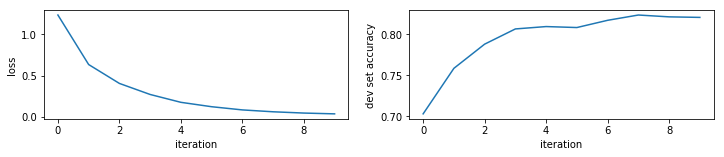

In [378]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

**Deliverable 5.3**: (*0.5 points*)
- As you can see from above, BiLSTM model performs worse than the Viterbi tagger.
- Use pretrained embeddings like the following to improve your performance.
- Check the following sources: [fastText](https://github.com/facebookresearch/fastText), [Polyglot](polyglot.readthedocs.io/en/latest/Embeddings.html), [word2vec](https://code.google.com/archive/p/word2vec/), [Glove](https://nlp.stanford.edu/projects/glove/)
- Tune the hyperparameters such that you obtain atleast `85.00%` accuracy on the dev set.
- You can try changing the no. of iterations, optimizers, no. of LSTM layers, the hidden dimension units, the FC layer dimensions, or use pretrained word embeddings like word2vec, fastText, polyglot, character features etc..
- **Tests**: ```test_bilstm.py: test_bilstm_dev_accuracy(), test_bilstm_test_accuracy()```

- **Remember: After training a model once, everytime when you rerun the train_model(...) function, the model is retrained on top of the previous parameters. If you want to start afresh, make sure the model is reinitialized and then trained.**

### Example: pretrained embeddings

- *Polyglot* provides pre-trained word embeddings for many languages
- You can download the english polyglot embeddings [here](https://sites.google.com/site/rmyeid/projects/polyglot).
- Use the following helper function to load in the polyglot embeddings, which you can use to initialize your parameter embeddings in your model. You need to make sure your embedding_dim matches your embeddings size.

In [427]:
reload(bilstm);
filename = 'data/polyglot-en.pkl'
word_embeddings = bilstm.obtain_polyglot_embeddings(filename, word_to_ix)

- Let us have a look at these word embeddings. We can observe the cosine similarity between two word vectors.

In [428]:
def cosine(emb1, emb2): #function to return the cosine similarity between the embeddings
    return emb1.dot(emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

In [109]:
diremb = word_embeddings[word_to_ix['dire']]
catemb = word_embeddings[word_to_ix['catastrophic']]
amazemb = word_embeddings[word_to_ix['success']]
print(cosine(diremb,catemb)) # dire and catastrophic are similar
print(cosine(diremb,amazemb))
print(cosine(catemb,amazemb))

0.6901981
0.05310622
0.08789002


- Now, all we need to do is send in the word_embeddings when initializing your model

In [429]:
torch.manual_seed(765);
embedding_dim=64
hidden_dim=150
model = bilstm.BiLSTM(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim, word_embeddings)

In [431]:
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr,Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=6, status_frequency=1, 
                                        optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')

Epoch 1: Dev Accuracy: 0.7717147752734941
Epoch 2: Dev Accuracy: 0.8055885066561224
Epoch 3: Dev Accuracy: 0.8203505997100303
Epoch 4: Dev Accuracy: 0.8244365361803084
Epoch 5: Dev Accuracy: 0.8299723210755239
Epoch 6: Dev Accuracy: 0.8384078028206142


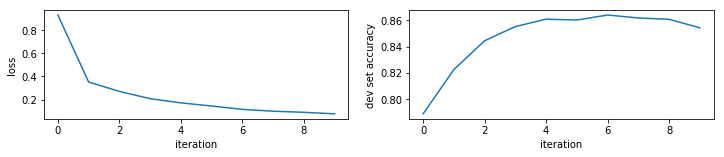

In [424]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

In [880]:
reload(tagger_base);
reload(bilstm);
confusion = tagger_base.eval_model(model,'bilstm-dev-en.preds', word_to_ix)

In [426]:
print (scorer.accuracy(confusion))

0.8538289178858574


In [427]:
tagger_base.apply_model(model,'bilstm-te-en.preds',word_to_ix, all_tags, testfile=TEST_FILE_HIDDEN)

In [107]:
# you don't have en-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(TEST_FILE,'bilstm-te-en.preds')
print (scorer.accuracy(te_confusion))

0.7503780068728523


- You may want to try other ideas like: learning rate, hidden layer sizes, optimizers, other pretrained embeddings for english etc. to improve the performance of the model.

### Part of Speech Tagging for Norwegian
Make sure your code runs on the Norwegian dataset as well. You may want to use the pretrained embeddings for norwegian to improve the performance of the model. However, there is no deliverable or test for this part.
- Run the `BiLSTM` model on the norwegian dataset using the `BiLSTM` tagger. 

In [881]:
#recalculating all_tags and tag_to_ix for the norwegian language
if START_TAG in all_tags_nr:
    all_tags_nr.remove(START_TAG)
if END_TAG in all_tags_nr:
    all_tags_nr.remove(END_TAG)

tag_to_ix_nr={}
for tag in all_tags_nr:
    if tag not in tag_to_ix_nr:
        tag_to_ix_nr[tag] = len(tag_to_ix_nr)

In [882]:
#recalculating the vocab for the norwegian language: obtains the most common 7600 words from the file
vocab_nr, word_to_ix_nr = most_common.get_word_to_ix(NR_TRAIN_FILE, 7600)
print ('words in the vocabulary: ',len(word_to_ix_nr))
print (word_to_ix_nr[UNK])

words in the vocabulary:  7600
7599


- Loading training data for norwegian:

In [918]:
reload(preproc);
X_tr_nr, Y_tr_nr = preproc.load_data(NR_TRAIN_FILE)

- Loading dev data for norwegian:

In [919]:
X_dv_nr, Y_dv_nr = preproc.load_data(NR_DEV_FILE)

- Loading test data for norwegian:

In [920]:
X_te_nr, Y_te_nr = preproc.load_data(NR_TEST_FILE_HIDDEN)

In [886]:
#setting up the random seed
torch.manual_seed(765);

# initializing your model
embedding_dim=30
hidden_dim=30
model = bilstm.BiLSTM(len(word_to_ix_nr),tag_to_ix_nr,embedding_dim, hidden_dim)

In [112]:
# training your model for norwegian data
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_nr,Y_tr_nr, word_to_ix_nr, tag_to_ix_nr, 
                                        X_dv_nr, Y_dv_nr, num_its=10, status_frequency=2, 
                                        optim_args = {'lr':0.2,'momentum':0}, param_file = 'best.params')

Epoch 1: Dev Accuracy: 0.6328169822145726
Epoch 3: Dev Accuracy: 0.7308089500860585
Epoch 5: Dev Accuracy: 0.7577739529546759
Epoch 7: Dev Accuracy: 0.7927710843373494
Epoch 9: Dev Accuracy: 0.8055077452667814


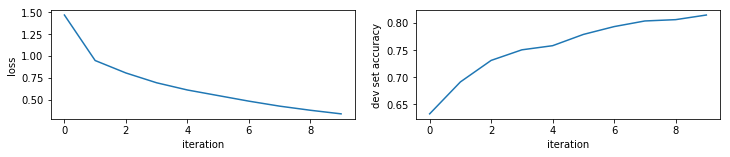

In [113]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

In [114]:
reload(tagger_base);
reload(bilstm);
confusion = tagger_base.eval_model(model,'bilstm-dev-nr.preds', word_to_ix_nr, 
                                   trainfile=NR_TRAIN_FILE, testfile=NR_DEV_FILE)

In [115]:
print (scorer.accuracy(confusion))

0.8139988525530695


In [116]:
tagger_base.apply_model(model,'bilstm-te-nr.preds',word_to_ix_nr, all_tags_nr, 
                        trainfile=NR_TRAIN_FILE, testfile=NR_TEST_FILE_HIDDEN)

In [117]:
# you don't have no_bokmaal-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(NR_TEST_FILE,'bilstm-te-nr.preds')
print (scorer.accuracy(te_confusion))

0.8049471785622262


# Using cuda
If you want to run the code on a GPU: 
- make sure you convert the input and target Tensors to be cuda Variables like below:

`inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())`
- and convert your model to cuda:

 `model.cuda()`

The following links would be useful: when you want to run your model on a GPU:  
 - [pytorch_doc](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu)
 - [mnist pytorch gpu example](https://github.com/pytorch/examples/blob/master/mnist/main.py)

6. Adding a CRF on top of BiLSTM
=================

We will now be building a `CRF` on top of the `BiLSTM` for Part-of-Speech tagging. The LSTM tagger above is typically sufficient for part-of-speech tagging, but a sequence model like the CRF might be helpful for tasks like Named Entity Recognition where the transitions and the overall structure is very important.

Recall that the `CRF` computes a conditional probability. Let Y be a tag sequence and X an input sequence of words. Then we compute  

$P (Y \mid X) = \frac{exp(Score(X,Y))}{\sum_{Y_i}exp(Score(X,Y_i))}$    
where the the score is determined by defining some log potentials $\log\Psi(X,Y)$ such that these potential only look at the local features.  

In the Bi-LSTM CRF, we define two kinds of potentials: emission and transition. 
- The emission potential for the word at index $i$ comes from the hidden state of the Bi-LSTM at timestep $i$. 
- The transition scores are stored in a `|T|x|T|` matrix `transitions`, where T is the tag set. In my implementation, `transitions[j][k]` is the score of transitioning to tag k from tag j.

$ Score(X,Y) = \sum_{i}\log\Psi_{emit}(y_i \rightarrow x_i) + \sum_{i}\log\Psi_{trans}(y_{i-1} \rightarrow y_{i}) \\
 Score(X,Y) = \sum_{i} h_{i}[y_{i}] + transitions_{y_i,y_{i-1}} $
 
See the notes for more details on this.

- Since, we are now using a `CRF`, we need to add `START_TAG` and `END_TAG` to the tagset: so, we modify `tag_to_ix` and `ix_to_tag` below.

In [887]:
#adding START_TAG and END_TAG to all_tags, updating tag_to_ix
if START_TAG not in all_tags:
    all_tags.append(START_TAG)
if END_TAG not in all_tags:
    all_tags.append(END_TAG)
all_tags = sorted(all_tags)
if START_TAG not in tag_to_ix:
    tag_to_ix[START_TAG] = len(tag_to_ix)
if END_TAG not in tag_to_ix:
    tag_to_ix[END_TAG] = len(tag_to_ix)

- We have already provided the transitions parameter to the `bilstm.BiLSTM_CRF` class. Take a look at it.

In [432]:
# setting random seed
reload(bilstm);
print(tag_to_ix)

{'--END--': 0, '--START--': 1, 'ADJ': 2, 'ADP': 3, 'ADV': 4, 'AUX': 5, 'CONJ': 6, 'DET': 7, 'INTJ': 8, 'NOUN': 9, 'NUM': 10, 'PART': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}


In [889]:
# initializing model
torch.manual_seed(765);
embedding_dim=30
hidden_dim=30
model = bilstm.BiLSTM_CRF(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)
print (model)

BiLSTM_CRF(
  (word_embeds): Embedding(6900, 30)
  (lstm): LSTM(30, 15, bidirectional=True)
  (hidden2tag): Linear(in_features=30, out_features=19)
)


- Observe that `BiLSTM_CRF` class is derived from the `BiLSTM` class
- Note that we would be using the forward function from `bilstm.BiLSTM` class to obtain the lstm hidden states

In [890]:
# let us prepare an input sequence
sentence = bilstm.prepare_sequence(X_tr[5], word_to_ix)

In [891]:
lstm_feats = model.forward(sentence)
print (lstm_feats[0][0:5])

Variable containing:
-0.2339
 0.1689
 0.0046
 0.0083
 0.0977
[torch.FloatTensor of size 5]



**Deliverable 6.1** (*0.5 points*) 
Complete the `bilstm.BiLSTM_CRF.forward_alg()` function to do the following:  
This function calculates the log likelihood score for a particular sentence. It works very similar to the `viterbi` algorithm: Instead of finding the maximum `prev_tag`, you need to calculate the probability to arrive at the `curr_tag` for the `curr_token`. The forward algorithm is described in chapter 6 of the class notes.

- **Inputs**: `feats`, the hidden states for each token in the input_sequence. Consider this to be the emission potential of each token for each tag.
    - Make sure to use the `self.transitions` that is defined to capture the tag-transition probabilities
- **Outputs**: `alpha`, a pytorch variable containing the scalar score for the entire input, $\log \sum_{y_{1:M}} P(w, y)$ 
- **Tests**: ```test_bilstm_crf.py: test_forward_alg()```

In [892]:
torch.manual_seed(765);

In [893]:
reload(bilstm);
model = bilstm.BiLSTM_CRF(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [894]:
# passing an input sentence to obtain lstm_feats
lstm_feats = model.forward(sentence)

In [895]:
alpha = model.forward_alg(lstm_feats)
print (alpha.data.numpy())

[42.802666]


**Deliverable 6.2** (*0.5 points*)
Complete the function `bilstm.BiLSTM_CRF.score_sentence()` to obtain the joint log-likelihood score of the particular sequence of tokens and their tags.
- **Inputs**:
    - `feats`: the hidden state scores for each token in the input sentence. Consider this to be the emission potential of each token for each tag.
    - `gold_tags`: a pytorch Variable of the gold sequence of tags: obtain the joint-log-likelihood score of the sequence with the feats and gold_tags.
- **Outputs**:
    - a pytorch variable of the score. 
- **Tests**: ```test_bilstm_crf.py: test_score_sentence()```

In [896]:
torch.manual_seed(765);

In [901]:
reload(bilstm);
model = bilstm.BiLSTM_CRF(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [902]:
# prepare both the tokens and tags to be passed as input
sentence = bilstm.prepare_sequence(X_tr[5], word_to_ix)
tags = bilstm.prepare_sequence(Y_tr[5], tag_to_ix)

In [903]:
torch.manual_seed(765);
lstm_feats = model.forward(sentence)

In [904]:
score = model.score_sentence(lstm_feats, tags)
print (score.data.numpy())

[-0.76696837]


** Deliverable 6.3 ** (*0.5 points* for 4650, *0.25 points* for 7650) Complete the `bilstm.BiLSTM_CRF.predict()` function to decode the tags using the viterbi algorithm. Make sure to use the viterbi functions defined previously.
- **Inputs**:
    - `sentence`: a pytorch Variable of sequence of ids of the input_tokens
- **Outputs**:
    - `best_path`: a list of tags for the sequence of tokens
- **Tests**: ```test_bilstm_crf.py: test_predict()```

In [907]:
reload(bilstm);
torch.manual_seed(765);
print(X_tr[5])

['The', 'third', 'was', 'being', 'run', 'by', 'the', 'head', 'of', 'an', 'investment', 'firm', '.']


In [908]:
model = bilstm.BiLSTM_CRF(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [909]:
best_tags = model.predict(sentence)
print (best_tags)

['PROPN', 'SYM', 'PROPN', 'X', 'PROPN', 'SYM', 'PROPN', 'SYM', 'SYM', 'SYM', 'SYM', 'SYM', 'PROPN']


**Deliverable 6.4** (*0.5 points* for 4650, *0.25 points* for 7650)
Complete the `bilstm.BiLSTM_CRF.neg_log_likelihood()` function to obtain the negative log likelihood loss. This function calculates the loss function for the `CRF`. Observe that, this can be easily calculated using the previously defined functions.  
You should use the `forward(), forward_alg(), score_sentence()` functions defined previously.

- **Tests**: ```test_bilstm_crf.py: test_neg_log_likelihood()```

In [ ]:
#setting random seed
reload(bilstm);

In [ ]:
torch.manual_seed(765);
model = bilstm.BiLSTM_CRF(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [ ]:
lstm_feats = model.forward(sentence)

In [ ]:
loss = model.neg_log_likelihood(lstm_feats, bilstm.prepare_sequence(Y_tr[5], tag_to_ix))
print (loss)

- Putting all the above components together, let us train the `BiLSTM-CRF` model. **Don't worry about matching the scores for the following code blocks from now. Just Make sure that you pass the unit tests.** 
- You may want to use pretrained embeddings to improve the performance of the model.

In [915]:
reload(bilstm);
torch.manual_seed(765);
embedding_dim=30
hidden_dim=30
model = bilstm.BiLSTM_CRF(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [916]:
# sending loss function so that we can calculate the loss for the BiLSTM-CRF
loss = model.neg_log_likelihood
model, losses, accuracies = bilstm.train_model(loss, model, X_tr,Y_tr, word_to_ix, tag_to_ix,
                                               X_dv, Y_dv, 
                                               num_its=10, status_frequency=2,
                                               optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')

KeyboardInterrupt: 

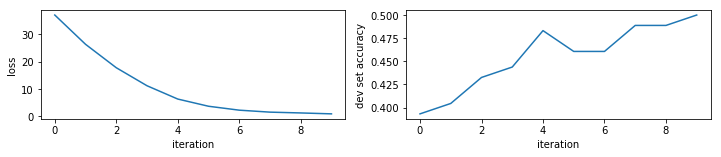

In [158]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

- Try and Tune the hyperparameters such that you improve the accuracy on the dev set.
You can try changing the number of LSTM layers, the hidden dimension units, the FC layer dimensions, using pretrained embeddings etc..

In [159]:
reload(bilstm);
torch.manual_seed(765);
embedding_dim=30
hidden_dim=30
model = bilstm.BiLSTM_CRF(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [160]:
# sending loss function so that we can calculate the loss for the BiLSTM-CRF
loss = model.neg_log_likelihood
model, losses, accuracies = bilstm.train_model(loss, model, X_tr,Y_tr, word_to_ix, tag_to_ix,
                                               X_dv, Y_dv, 
                                               num_its=5, status_frequency=1,
                                               optim_args = {'lr':0.2,'momentum':0}, param_file = 'best.params')

Epoch 1: Dev Accuracy: 0.29213483146067415
Epoch 2: Dev Accuracy: 0.4044943820224719
Epoch 3: Dev Accuracy: 0.4157303370786517
Epoch 4: Dev Accuracy: 0.42134831460674155
Epoch 5: Dev Accuracy: 0.4606741573033708


In [ ]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

In [162]:
reload(tagger_base);
reload(bilstm);
confusion = tagger_base.eval_model(model,'bilstm_crf-dev-en.preds', word_to_ix)

In [163]:
print (scorer.accuracy(confusion))

0.38961381310135756


In [164]:
tagger_base.apply_model(model,'bilstm_crf-te-en.preds',word_to_ix, all_tags, testfile=TEST_FILE_HIDDEN)

In [165]:
# you don't have en-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(TEST_FILE,'bilstm_crf-te-en.preds')
print (scorer.accuracy(te_confusion))

0.39670103092783504


In [ ]:
print (scorer.accuracy(confusion))

### Part of Speech Tagging for Norwegian Language.
We will use the same `BiLSTM-CRF` part of speech tagger for Norwegian now.

- Running a `BiLSTM-CRF` model on the norwegian language. Make sure your model runs on the norwegian data. 
- You may want to use the pretrained embeddings for norwegian to improve the performance of the model.

In [433]:
if START_TAG not in all_tags_nr:
    all_tags_nr.append(START_TAG)
if END_TAG not in all_tags_nr:
    all_tags_nr.append(END_TAG)
all_tags_nr = sorted(all_tags_nr)
if START_TAG not in tag_to_ix_nr:
    tag_to_ix_nr[START_TAG]=len(tag_to_ix_nr)
if END_TAG not in tag_to_ix_nr:
    tag_to_ix_nr[END_TAG]=len(tag_to_ix_nr)
# we will be using this tag_to_ix and ix_to_tag from now on..

In [434]:
reload(bilstm);
torch.manual_seed(765);
embedding_dim=30
hidden_dim=30
model = bilstm.BiLSTM_CRF(len(word_to_ix_nr),tag_to_ix_nr,embedding_dim, hidden_dim)

In [168]:
# sending loss function so that we can calculate the loss for the BiLSTM-CRF
loss = model.neg_log_likelihood
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_nr, Y_tr_nr, word_to_ix_nr, tag_to_ix_nr,
                                               X_dv_nr, Y_dv_nr, 
                                               num_its=10, status_frequency=2,
                                               optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')

Epoch 1: Dev Accuracy: 0.34065934065934067
Epoch 3: Dev Accuracy: 0.37362637362637363
Epoch 5: Dev Accuracy: 0.3626373626373626
Epoch 7: Dev Accuracy: 0.3626373626373626
Epoch 9: Dev Accuracy: 0.4010989010989011


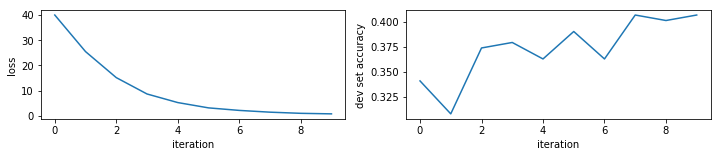

In [169]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

In [170]:
reload(tagger_base);
reload(bilstm);
confusion = tagger_base.eval_model(model,'bilstm_crf-dev-nr.preds', word_to_ix_nr, 
                                   trainfile=NR_TRAIN_FILE, testfile=NR_DEV_FILE)

In [171]:
print (scorer.accuracy(confusion))

0.344578313253012


In [172]:
tagger_base.apply_model(model,'bilstm_crf-te-nr.preds',word_to_ix_nr, all_tags_nr, 
                        trainfile=NR_TRAIN_FILE, testfile=NR_TEST_FILE_HIDDEN)


In [173]:
# you don't have no_bokmaal-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(NR_TEST_FILE,'bilstm_crf-te-nr.preds')
print (scorer.accuracy(te_confusion))

0.3550631280597784


7. Improve your Taggers performance
==================
**Deliverable 7.1** (*2.0 points*)
Improve your taggers performance to get atleast `87.00%` on the dev dataset for both English and Norwegian.
You can use any model that you have implemented in this assignment: HMM, BiLSTM, or BiLSTM-CRF.
- HMM is unlikely to score high enough for full credit
- BiLSTM-CRF is more accurate than BiLSTM in theory, but it takes a long time to train. So iterating on BiLSTM might be better.    
- Ideas: try varying the input (character-level features?), the optimizer, the model architecture, the pretrained embeddings, dropout, regularization, etc. Here are some more pretrained embeddings to try: [fastText](https://github.com/facebookresearch/fastText), [Polyglot](polyglot.readthedocs.io/en/latest/Embeddings.html), [word2vec](https://code.google.com/archive/p/word2vec/), [Glove](https://nlp.stanford.edu/projects/glove/).
- For Norwegian, there are officially [two written forms of language](https://en.wikipedia.org/wiki/Norwegian_language): `Bokmål` and `Nynorsk`. The dataset we are using is for the `Bokmål` language. So, when using pretrained embeddings make sure to use it for that specific form.

**Output files:** Make sure to name your files as follows: The unit tests will check for these files.
- `model-dev-en.preds` ( Predictions for the dev dataset of english ) 
- `model-te-en.preds`  ( Predictions for the test dataset of english ) 
- `model-dev-nr.preds` ( Predictions for the dev dataset of norwegian ) 
- `model-te-nr.preds`  ( Predictions for the test dataset of norwegian ) 

**Tests**: `test_performance.py`: 
- `test_en_dev_accuracy()`
- `test_en_test_accuracy()` #you cannot run this unit test.
- `test_nr_dev_accuracy()`
- `test_nr_test_accuracy()` #you cannot run this unit test.

## Rubric

Dev Set (both languages)
- $\geq$ 85% (*0.15 points*)
- $\geq$ 86% (*0.25 points*)
- $\geq$ 87% (*0.5 points*)

Test Set (both languages)
- $\geq$ 84% (*0.15 points*)
- $\geq$ 85% (*0.25 points*)
- $\geq$ 86% (*0.5 points*)


In [489]:
# English using Polyglot

reload(bilstm);
filename = 'data/polyglot-en.pkl'
word_embeddings = bilstm.obtain_polyglot_embeddings(filename, word_to_ix)

In [490]:
def cosine(emb1, emb2): #function to return the cosine similarity between the embeddings
    return emb1.dot(emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

In [491]:
diremb = word_embeddings[word_to_ix['dire']]
catemb = word_embeddings[word_to_ix['catastrophic']]
amazemb = word_embeddings[word_to_ix['success']]
print(cosine(diremb,catemb)) # dire and catastrophic are similar
print(cosine(diremb,amazemb))
print(cosine(catemb,amazemb))

0.6901981
0.05310622
0.08789002


In [494]:
torch.manual_seed(765);
embedding_dim=64
hidden_dim=128
model = bilstm.BiLSTM(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim, word_embeddings)

In [493]:
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr,Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=8, status_frequency=1, 
                                        optim_args = {'lr':0.1,'momentum': 0}, param_file = 'best.params')

Epoch 1: Dev Accuracy: 0.7590615526558587
Epoch 2: Dev Accuracy: 0.8037432450243838
Epoch 3: Dev Accuracy: 0.8235139053644391
Epoch 4: Dev Accuracy: 0.833662844339001
Epoch 5: Dev Accuracy: 0.8298405166732569
Epoch 6: Dev Accuracy: 0.833662844339001
Epoch 7: Dev Accuracy: 0.8446026097271648
Epoch 8: Dev Accuracy: 0.8409120864636879


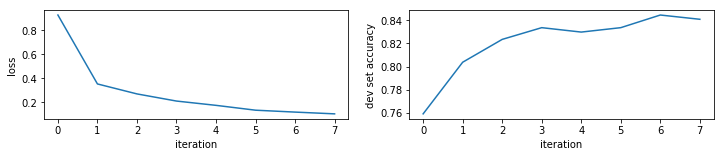

In [495]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

In [496]:
reload(tagger_base);
reload(bilstm);
confusion = tagger_base.eval_model(model,'hmm-dev-en-test.preds', word_to_ix)

In [497]:
print (scorer.accuracy(confusion))

0.03769605904837221


In [238]:
tagger_base.apply_model(model,'model-te-en.preds',word_to_ix, all_tags, testfile=TEST_FILE_HIDDEN)

In [ ]:
# you don't have en-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(TEST_FILE,'bilstm-te-en.preds')
print (scorer.accuracy(te_confusion))

In [469]:
# Norwegian
#recalculating all_tags and tag_to_ix for the norwegian language
#Using helper functions to obtain vocab, word_to_ix, tag_to_ix
all_tags_nr = sorted(list(tag_trans_counts_nr.keys()) + [END_TAG])
vocab_nr, word_to_ix_nr = most_common.get_word_to_ix(NR_TRAIN_FILE) #obtains all the words in the vocab
tag_to_ix_nr={}
for tag in list(all_tags_nr):
    tag_to_ix_nr[tag]=len(tag_to_ix_nr)
print (tag_to_ix_nr)

if START_TAG in all_tags_nr:
    all_tags_nr.remove(START_TAG)
if END_TAG in all_tags_nr:
    all_tags_nr.remove(END_TAG)

tag_to_ix_nr={}
for tag in all_tags_nr:
    if tag not in tag_to_ix_nr:
        tag_to_ix_nr[tag] = len(tag_to_ix_nr)

{'--END--': 0, '--START--': 1, 'ADJ': 2, 'ADP': 3, 'ADV': 4, 'AUX': 5, 'CCONJ': 6, 'DET': 7, 'INTJ': 8, 'NOUN': 9, 'NUM': 10, 'PART': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}


In [467]:
#recalculating the vocab for the norwegian language: obtains the most common 7600 words from the file
vocab_nr, word_to_ix_nr = most_common.get_word_to_ix(NR_TRAIN_FILE, 7600)
print ('words in the vocabulary: ',len(word_to_ix_nr))
print (word_to_ix_nr[UNK])

words in the vocabulary:  7600
7599


In [437]:
#reload(preproc);
#X_tr_nr, Y_tr_nr = preproc.load_data(NR_TRAIN_FILE)

In [438]:
#X_dv_nr, Y_dv_nr = preproc.load_data(NR_DEV_FILE)

In [474]:
#X_te_nr, Y_te_nr = preproc.load_data(NR_TEST_FILE_HIDDEN)# English using Polyglot

# Norwegian Polyglot embedding

reload(bilstm);
nr_filename = 'data/polyglot-no.pkl'
nr_word_embeddings = bilstm.obtain_polyglot_embeddings(nr_filename, word_to_ix_nr)

In [484]:
torch.manual_seed(765);
embedding_dim=64
hidden_dim=200
nr_model = bilstm.BiLSTM(len(word_to_ix_nr),tag_to_ix_nr,embedding_dim, hidden_dim, nr_word_embeddings)

In [485]:
loss = torch.nn.CrossEntropyLoss()
nr_model, nr_losses, nr_accuracies = bilstm.train_model(loss, nr_model, X_tr_nr,Y_tr_nr, word_to_ix_nr, tag_to_ix_nr, 
                                        X_dv_nr, Y_dv_nr, num_its=7, status_frequency=1, 
                                        optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')

Epoch 1: Dev Accuracy: 0.8066551921973609
Epoch 2: Dev Accuracy: 0.8506024096385543
Epoch 3: Dev Accuracy: 0.8627653471026965
Epoch 4: Dev Accuracy: 0.8688468158347676
Epoch 5: Dev Accuracy: 0.8781411359724612
Epoch 6: Dev Accuracy: 0.8783706253585771
Epoch 7: Dev Accuracy: 0.8792885829030407


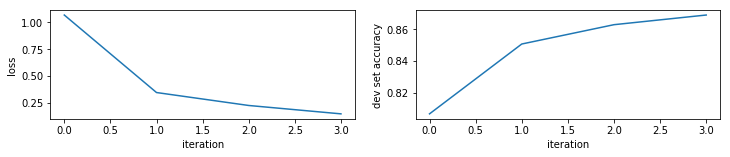

In [475]:
reload(bilstm);
bilstm.plot_results(nr_losses, nr_accuracies)

In [486]:
reload(tagger_base);
reload(bilstm);
confusion_nr = tagger_base.eval_model(nr_model, 'model-dev-nr.preds', word_to_ix_nr, 
                                   trainfile=NR_TRAIN_FILE, testfile=NR_DEV_FILE)

In [487]:
print (scorer.accuracy(confusion_nr))

0.8792885829030407


In [488]:
tagger_base.apply_model(nr_model,'model-te-nr.preds',word_to_ix_nr, all_tags_nr, trainfile=NR_TRAIN_FILE, testfile=NR_TEST_FILE_HIDDEN)

8. Bakeoff (Extra Credit)
==================

Try to get the best accuracy possible on both `English` and `Norwegian` tagging.

Some ideas:

- Better features, such as characters
- Better optimization
- Number of Layers and Hidden units in the BiLSTM
- More hidden layers in the Fully Connected Layer
- Better loss function: like structured perceptron
- Better preprocessing
- Using Pretrained Embeddings like [fastText](https://github.com/facebookresearch/fastText), [Polyglot](polyglot.readthedocs.io/en/latest/Embeddings.html), [word2vec](https://code.google.com/archive/p/word2vec/), [Glove](https://nlp.stanford.edu/projects/glove/)
- Dropout or other regularization scheme

The current best accuracies from the staff are:
- For English data:    
    - `88% dev`, 
    - `87.5% test`
- For Norwegian data:  
    - `89% dev`, 
    - `87.8% test`

However, these accuracies may improve before the end of the bakeoff!   
 

**Output files:** In addition to participating in the kaggle bakeoff, make sure to name your files as follows:

- `bakeoff-dev-en.preds` ( Predictions for the dev dataset of english ) 
- `bakeoff-te-en.preds`  ( Predictions for the test dataset of english ) 
- `bakeoff-dev-nr.preds` ( Predictions for the dev dataset of norwegian ) 
- `bakeoff-te-nr.preds`  ( Predictions for the test dataset of norwegian ) 

The unit tests will check for these files. To get the extra credit, you must both participate in Kaggle and submit these files.

**Rubric**

- Top 3 final score on Kaggle in English: +0.5%
- Top 3 final score on Kaggle in Norwegian: +0.5%
- Beat best staff final score on Kaggle in English: +0.5%
- Best best staff final score on Kaggle in Norwegian: +0.5%

# 9. 7650 Research Question  

(*1 point*)

You will select a recent research paper that performs **sequence labeling** either POS tagging or some other task within the last five years (2014-2018). Summarize the paper, answering the following questions:

- List the title, author(s) and venue of the paper.
- What is the task they are trying to solve?
- What tagging methods do they use? HMMs, CRF?, max-margin markov networks, deep learning models?
- What features do they use and why?
- What methods and features are most effective?
- Give a one-line summary of the paper that the authors are trying to leave for the reader.

Your selection of papers is determined by the last digit of your GTID.

- Digits 0-4: choose from NAACL, EMNLP, or NIPS
- Digits 5-9: choose from ACL, EACL, or TACL

You must choose a paper in the main conference (not workshops). The paper must be at least four pages long. All papers from these conferences are available for free online.